This example illustrates various tools for assaying, assessing, modifying and preparing data prior to   
modeling. It uses BANK_RAW  dataset as input and produces _PREPPED dataset.    

The _PREPPED dataset is not used in subsequent examples.                                  
                                                                      
The steps include:                                                  
                                                                      
1.  PREPARE AND EXPLORE  
  a) Load data set into CAS  
  b) Explore  
  c) Impute  
  d) Identify variables that explain variance  
  e) Perform a cluster analysis to identify homogeneous groups in the data  
  f) Perform principal components analysis to assess collineary among candidate, interval valued inputs       

### Import packages

In [1]:
from swat import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='localhost'
casport=5570
casauth='~/.authinfo'

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

### Details for local data to be loaded into CAS

In [4]:
indata_dir="/opt/sasinside/DemoData"
indata="bank_raw"

### Import table action set

In [5]:
sess.loadactionset(actionset="table")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="varReduce")
sess.loadactionset(actionset="clustering")
sess.loadactionset(actionset="pca")
sess.loadactionset(actionset="simple")

NOTE: Added action set 'table'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'varReduce'.
NOTE: Added action set 'clustering'.
NOTE: Added action set 'pca'.
NOTE: Added action set 'simple'.


[actionset]

 'simple'

+ Elapsed: 0.0002s, sys: 0.001s, mem: 0.0281mb

### Load data into CAS

In [6]:
if not sess.table.tableExists(table=indata).exists:
    tbl = sess.upload_file(indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the uploaded file available as table BANK_RAW in caslib CASUSER(viyauser).
NOTE: The table BANK_RAW has been created in caslib CASUSER(viyauser) from binary data uploaded to Cloud Analytic Services.


### Explore the data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 1.355444 seconds.
----------------------------------Data Summary----------------------------------


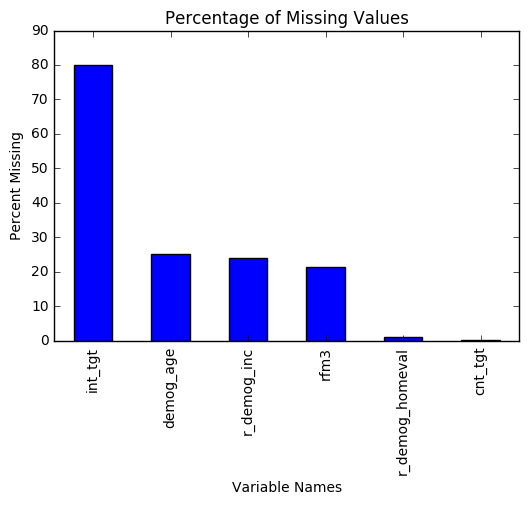

In [7]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
df_data_card = df_data_card.sort_values(by=['PERCENT_MISSING'], ascending=False)

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

### Impute missing values

In [8]:
# Pipelined imputation using transform action
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"demog_age"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"int_tgt", "rfm3"}},
  ]
)

[TransInfo]

 Transformation Requests for BANK_RAW
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           1         Mean
 1       _TR2           2       Median

[VarTransInfo]

 Variable Transformation Information for BANK_RAW
 
     Variable Transformation     ResultVar       N   NMiss  \
 0  demog_age             IM  IM_demog_age  793177  266861   
 1    int_tgt             IM    IM_int_tgt  211509  848529   
 2       rfm3             IM       IM_rfm3  834252  225786   
 
    ImputedValueContinuous  
 0               58.716371  
 1            10000.000000  
 2               14.000000  

[OutputCasTables]

               casLib      Name     Rows  Columns  \
 0  CASUSER(viyauser)  _prepped  1060038       28   
 
                                            casTable  
 0  CASTable('_prepped', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.786s, user: 3.05s, sys: 0.392s, mem: 50.8mb

### Identify variables that explain variance in the target

NOTE: The CAS table 'SelectionSummary' in caslib 'CASUSER(viyauser)' has 10 rows and 9 columns.


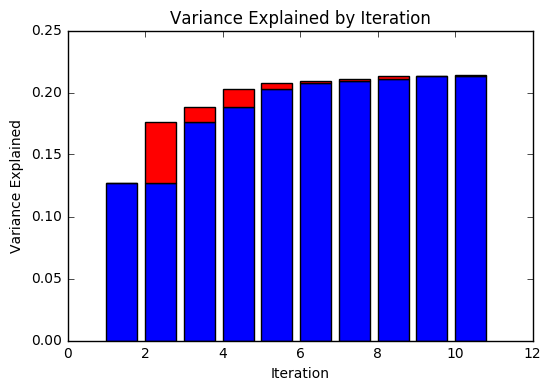

In [9]:
#/* Discriminant analysis for class target */
sess.varReduce.super(
  table={"name":"_prepped"},
  analysis="DSC",
  classVars=[{"vars":{"b_tgt", "cat_input1", "cat_input2"}}],
  model={
    "depVars":[{"name":"b_tgt"}],
    "effects":[{"vars":{"cat_input1", "cat_input2", "rfm1", "rfm2", 
                        "rfm3", "rfm4", "rfm5", "rfm6", "rfm7", "rfm8",
                        "rfm9", "rfm10", "rfm11", "rfm12"}}]
  },
  maxeffects=8,
  outputTables={"names":{"SelectionSummary"}}  
)

# Compute Increment and Base variables
selsum=sess.CASTable("SelectionSummary")
selsum.vars=['Iteration', 'Variable', 'VarExp']
allRows=30000  # Assuming max rows in SelectionSummary table is <= 20,000
plot_df=selsum.fetch(to=allRows)['Fetch']
 
plot_df["Increment"]=0
prevVarExp=0
for i, row in plot_df.iterrows():
    if i==0:
        prevVarExp=row["VarExp"]
    else:
        plot_df.loc[i, "Increment"]=row["VarExp"]-prevVarExp
        prevVarExp=row["VarExp"]
plot_df["Base"]=plot_df["VarExp"]-plot_df["Increment"]

#/* Variance explained by Iteration plot */       
plt.bar(plot_df["Iteration"], plot_df["Base"], color='b')
plt.bar(plot_df["Iteration"], plot_df["Increment"], color='r', bottom=plot_df["Base"])
plt.xlabel("Iteration")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Iteration")
plt.show()

### Perform a cluster analysis based on demographic inputs

In [10]:
sess.clustering.kClus(
  table={"name":"_prepped"},
  inputs={"r_demog_inc", "r_demog_homeval", "demog_age"},
  distance="EUCLIDEAN",
  standardize="STD",
  nClusters=6
)

NOTE: Using SEED=1099407780.
NOTE: Running for input data for K 6.
NOTE: Clustering is finished. MAXITER is satisfied.


,Type,N
0,Number of Observations Read,1060038.0
1,Number of Observations Used,688699.0
,Parameter,Setting
0,Clustering Algorithm,K-means
1,Maximum Iterations,10
2,Stop Criterion,Cluster Change
3,Stop Criterion Value,0
4,Clusters,6
5,Initialization,Forgy
6,Seed,1099407780


### Perform a principal components analysis on the interval valued input variables  

In [11]:
p = sess.pca.eig(
  table={"name":"_prepped"},
  inputs={"rfm1", "rfm2", "IM_rfm3", "rfm4", "rfm5", "rfm6", "rfm7", "rfm8", "rfm9", "rfm10", 
          "rfm11", "rfm12"}
)

render_html(p)

Model Information 
 Description 
 Value 
 
 
 Data Source _PREPPED 
 Component Extraction Method Eigenvalue Decomposition 
 
 
 
 
 Number of Variables 
 Description 
 Value 
 
 
 Number of Variables 12 
 Number of Principal Components 12 
 
 
 
 
 Number of Observations 
 Description 
 Value 
 
 
 Number of Observations Read 1060038 
 Number of Observations Used 1060038 
 
 
 
 
 Simple Statistics 
 Variable 
 Label 
 Mean 
 Standard Deviation 
 
 
 rfm2 Average Sales Lifetime 13.35153853 9.4708880151 
 IM_rfm3 15.030881978 16.834526937 
 rfm4 Last Product Purchase Amount 17.471679468 37.550542726 
 rfm7 Count Prchsd Past 3 Years Dir Promo Resp 1.6666817605 1.5256840535 
 rfm10 Count Total Promos Past Year 12.889713388 4.6073680923 
 rfm8 Count Prchsd Lifetime Dir Promo Resp 5.0259245423 4.5100987262 
 rfm6 Count Purchased Lifetime 9.5390042621 8.4721275024 
 rfm12 Customer Tenure 68.134781961 37.349303386 
 rfm5 Count Purchased Past 3 Years 2.9077967016 2.0285762463 
 rfm11 Count Direct Promos Past Year 5.3585729946 1.3603719572 
 rfm1 Average Sales Past 3 Years 16.092977374 19.302513058 
 rfm9 Months Since Last Purchase 18.351553435 4.0216092812 
 
 
 
 
 Correlation Matrix 
 Variable 
 Label 
 rfm2 
 IM_rfm3 
 rfm4 
 rfm7 
 rfm10 
 rfm8 
 rfm6 
 rfm12 
 rfm5 
 rfm11 
 rfm1 
 rfm9 
 
 
 rfm2 Average Sales Lifetime 1 0.5597942757 0.4390247972 -0.216713664 0.0880965965 -0.296437304 -0.291271738 -0.241744709 -0.304213511 -0.015654169 0.6355535159 0.0349031684 
 IM_rfm3 0.5597942757 1 0.4399435142 -0.104417169 0.0616701894 -0.094887782 -0.103793141 -0.041700886 -0.165107845 0.0107433959 0.8206094701 0.0264768235 
 rfm4 Last Product Purchase Amount 0.4390247972 0.4399435142 1 -0.074764182 0.0365818778 -0.063018519 -0.060691497 -0.022706997 -0.09427416 0.0116687482 0.7883615478 0.024502097 
 rfm7 Count Prchsd Past 3 Years Dir Promo Resp -0.216713664 -0.104417169 -0.074764182 1 0.1757489101 0.5298305771 0.4335978241 0.0916510566 0.8385133126 0.3656788164 -0.138006533 -0.076670344 
 rfm10 Count Total Promos Past Year 0.0880965965 0.0616701894 0.0365818778 0.1757489101 1 0.1998478613 0.3134862687 0.1814408961 0.2162325339 0.6087359418 0.0599460483 -0.460850553 
 rfm8 Count Prchsd Lifetime Dir Promo Resp -0.296437304 -0.094887782 -0.063018519 0.5298305771 0.1998478613 1 0.9154240187 0.746605062 0.5228585636 0.2163327502 -0.109586409 -0.067039873 
 rfm6 Count Purchased Lifetime -0.291271738 -0.103793141 -0.060691497 0.4335978241 0.3134862687 0.9154240187 1 0.7333621016 0.5310401466 0.2442016511 -0.109173023 -0.134344663 
 rfm12 Customer Tenure -0.241744709 -0.041700886 -0.022706997 0.0916510566 0.1814408961 0.746605062 0.7333621016 1 0.1824912297 0.1526364591 -0.031881443 -0.018171199 
 rfm5 Count Purchased Past 3 Years -0.304213511 -0.165107845 -0.09427416 0.8385133126 0.2162325339 0.5228585636 0.5310401466 0.1824912297 1 0.428530634 -0.175246253 -0.155010425 
 rfm11 Count Direct Promos Past Year -0.015654169 0.0107433959 0.0116687482 0.3656788164 0.6087359418 0.2163327502 0.2442016511 0.1526364591 0.428530634 1 0.0193051018 -0.201832246 
 rfm1 Average Sales Past 3 Years 0.6355535159 0.8206094701 0.7883615478 -0.138006533 0.0599460483 -0.109586409 -0.109173023 -0.031881443 -0.175246253 0.0193051018 1 0.0318533648 
 rfm9 Months Since Last Purchase 0.0349031684 0.0264768235 0.024502097 -0.076670344 -0.460850553 -0.067039873 -0.134344663 -0.018171199 -0.155010425 -0.201832246 0.0318533648 1 
 
 
 
 
 Eigenvalues 
 Number 
 Eigenvalue 
 Difference 
 Proportion 
 Cumulative 
 
 
 1 3.9308251554 1.2525338225 0.327568763 0.327568763 
 2 2.6782913329 1.0675575973 0.2231909444 0.5507597074 
 3 1.6107337356 0.3647263482 0.1342278113 0.6849875187 
 4 1.2460073874 0.484631259 0.1038339489 0.7888214676 
 5 0.7613761284 0.1748544742 0.0634480107 0.8522694783 
 6 0.5865216543 0.1458140308 0.0488768045 0.9011462828 
 7 0.4407076234 0.1420314641 0.0367256353 0.9378719181 
 8 0.2986761593 0.1250633743 0.0248896799 0.9627615981 
 9 0.173612785 0.003644

### Output Scree Plot and Variance Explained Plot

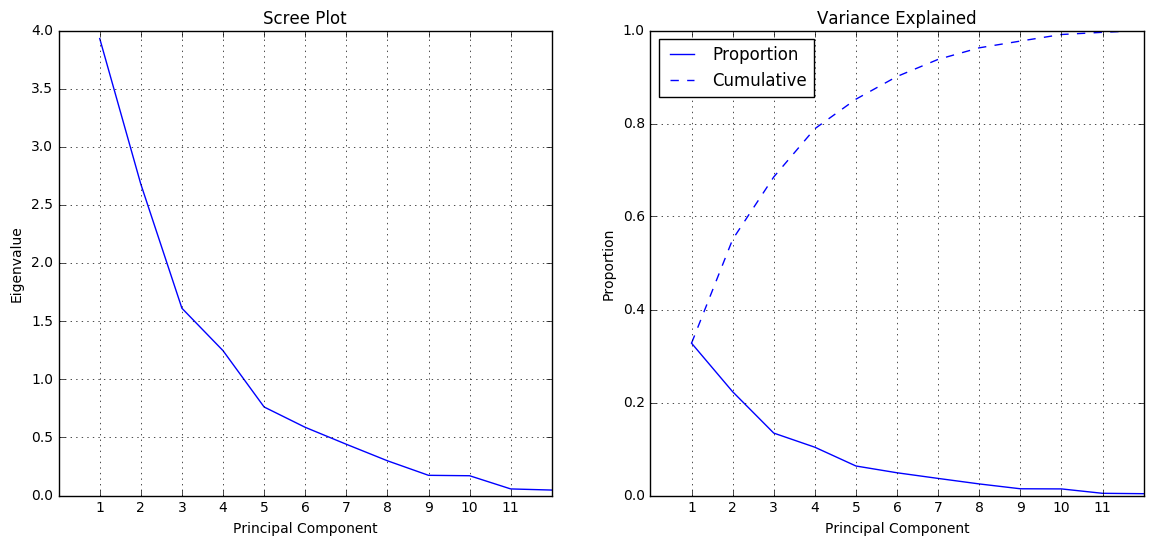

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(p.Eigenvalues.Number, p.Eigenvalues.Eigenvalue)
plt.xticks(np.arange(1, 12, 1.0))
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.title("Scree Plot")

plt.subplot(1, 2, 2)
plt.plot(p.Eigenvalues.Number, p.Eigenvalues.Proportion, label="Proportion")
plt.plot(p.Eigenvalues.Number, p.Eigenvalues.Cumulative, linestyle='dashed', color="b", label="Cumulative")
plt.xticks(np.arange(1, 12, 1.0))
plt.xlabel("Principal Component")
plt.ylabel("Proportion")
plt.grid(True)
plt.legend(loc="best")
plt.title("Variance Explained");

### End CAS session

In [13]:
sess.close()